In [1]:
!pip install -U pip
!pip uninstall -y huggingface_hub sentence-transformers transformers langchain langchain-community langchain-text-splitters langchain-huggingface

!pip install -U \
  langchain \
  langchain-community \
  langchain-text-splitters \
  langchain-huggingface \
  langgraph \
  chromadb \
  tiktoken

!pip install -U huggingface_hub==0.23.5 sentence-transformers==2.7.0 transformers

Found existing installation: huggingface-hub 0.23.5
Uninstalling huggingface-hub-0.23.5:
  Successfully uninstalled huggingface-hub-0.23.5
Found existing installation: sentence-transformers 2.7.0
Uninstalling sentence-transformers-2.7.0:
  Successfully uninstalled sentence-transformers-2.7.0
Found existing installation: transformers 4.46.3
Uninstalling transformers-4.46.3:
  Successfully uninstalled transformers-4.46.3
Found existing installation: langchain 1.2.10
Uninstalling langchain-1.2.10:
  Successfully uninstalled langchain-1.2.10
Found existing installation: langchain-community 0.4.1
Uninstalling langchain-community-0.4.1:
  Successfully uninstalled langchain-community-0.4.1
Found existing installation: langchain-text-splitters 1.1.1
Uninstalling langchain-text-splitters-1.1.1:
  Successfully uninstalled langchain-text-splitters-1.1.1
Found existing installation: langchain-huggingface 1.2.0
Uninstalling langchain-huggingface-1.2.0:
  Successfully uninstalled langchain-huggingfa

In [2]:
!pip -q install cassio

In [3]:
import cassio
from google.colab import userdata

ASTRA_DB_TOKEN = userdata.get("ASTRA_DB_TOKEN")
ASTRA_DB_ID = userdata.get("ASTRA_DB_ID")

if not ASTRA_DB_TOKEN or not ASTRA_DB_ID:
    raise ValueError("Set ASTRA_DB_APPLICATION_TOKEN and ASTRA_DB_ID in Colab Secrets")

cassio.init(token=ASTRA_DB_TOKEN, database_id=ASTRA_DB_ID)

In [4]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

In [5]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

In [6]:
from langchain_community.vectorstores import Cassandra

astra_vector_store=Cassandra(
    embedding=embeddings,
    table_name="qa_mini_demo",
    session=None,
    keyspace=None

)

In [7]:
astra_vector_store.add_documents(doc_splits)
print("Inserted %i chunks." % len(doc_splits))

retriever = astra_vector_store.as_retriever(search_kwargs={"k": 4})

Inserted 88 chunks.


In [8]:
retriever=astra_vector_store.as_retriever()

In [9]:
retriever.invoke("What is agent",ConsistencyLevel="LOCAL_ONE")

[Document(id='427e6227557040e3a4c646fc940cab3f', metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nShort-term memory: I would consider all the in-context lear

In [10]:
from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

In [11]:
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "wiki_search"] = Field(
        ...,
        description="Given a user question choose to route it to wikipedia or a vectorstore.",
    )

In [12]:
!pip -q install langchain_groq

In [13]:
from google.colab import userdata
from langchain_groq import ChatGroq
import os

groq_api_key=userdata.get('groq_api_key')
os.environ["GROQ_API_KEY"]=groq_api_key

llm=ChatGroq(groq_api_key=groq_api_key,model_name="Llama-3.3-70b-Versatile")

structured_llm_router = llm.with_structured_output(RouteQuery)

In [14]:
system = """You are an expert at routing a user question to a vectorstore or wikipedia.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. Otherwise, use wiki-search."""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router

In [15]:
print(
    question_router.invoke(
        {"question": "who is Sharukh Khan?"}
    )
)

datasource='wiki_search'


In [16]:
print(
    question_router.invoke(
        {"question": "who is RAG?"}
    )
)

datasource='vectorstore'


In [17]:
!pip -q install langchain_community
!pip -q install wikipedia

In [18]:
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import WikipediaQueryRun

api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=200)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper)

In [19]:
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

In [20]:
from langchain_core.documents import Document

def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]


    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

In [21]:
def wiki_search(state):
    """
    wiki search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---wikipedia---")
    question = state["question"]
    print(question)

    docs = wiki.invoke({"query": question})
    wiki_results = docs
    wiki_results = Document(page_content=wiki_results)

    return {"documents": wiki_results, "question": question}

In [22]:
def route_question(state):
    """
    Route question to wiki search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "wiki_search":
        print("---ROUTE QUESTION TO Wiki SEARCH---")
        return "wiki_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

In [23]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

workflow.add_node("wiki_search", wiki_search)   # web search
workflow.add_node("retrieve", retrieve)   # retrieve


workflow.add_conditional_edges(
    START,
    route_question,
    {
        "wiki_search": "wiki_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge( "retrieve", END)
workflow.add_edge( "wiki_search", END)

In [24]:
app = workflow.compile()

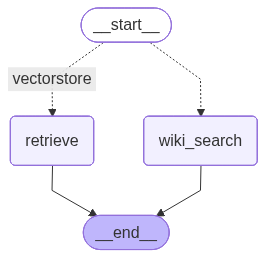

In [25]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [26]:
from pprint import pprint

inputs = {
    "question": "What is agent?"
}

for output in app.stream(inputs):
    for key, value in output.items():
        print(f"Node '{key}':")
        pprint(value, indent=2, width=80, depth=None)
        print("\n---\n")

if "documents" in value and len(value["documents"]) > 0:
    print(value["documents"][0].metadata.get("description"))

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---


Node 'retrieve':
{ 'documents': [ Document(id='427e6227557040e3a4c646fc940cab3f', metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nShort-term memory: I would

In [27]:
from pprint import pprint

inputs = {
    "question": "Prabhas"
}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Node '{key}':")

pprint(value['documents'])

---ROUTE QUESTION---
---ROUTE QUESTION TO Wiki SEARCH---
---wikipedia---
Prabhas
"Node 'wiki_search':"
Document(metadata={}, page_content='Page: Prabhas\nSummary: Uppalapati Venkata Suryanarayana Prabhas Raju  ([pɾabʱaːs]; born 23 October 1979), known mononymously as Prabhas, is an Indian actor who predominantly works in Telugu cinema. He')
